# Machine Learning - Project 2 - 2018
## Fatine Benhsain - Tabish Qureshi - Ayyoub El Amrani
### Recommender System

# 1. Introduction

The goal of the project is to create a recommendation systems for movies based on data......bla bla

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In order to preprocess and use the data, the library pandas is used. The later provides very useful tools in this framework.

# 2. Data Importation & Preprocessing

This step is made for importing data and prepare them before implementing a machine learning method. The preprocessing includes steps such as exploration, wrangling... and can be used for feature engineering.

## 2.1 Training Set Importation

In [2]:
raw_data = pd.read_csv('data/data_train.csv')

Before starting anything, the data will be explored in order to perform data wrangling and features engineering.

In [3]:
raw_data['Prediction'].value_counts()

5    435237
4    324700
3    274327
2     99180
1     43508
Name: Prediction, dtype: int64

In [4]:
raw_data.head()

,Id,Prediction
0,r44_c1,4
1,r61_c1,3
2,r67_c1,4
3,r72_c1,3
4,r86_c1,5


The data are stacked into 2 columns with the Id rX_cY. X corresponds to a user and Y corresponds to the movie.
In order to make a proper analysis, one needs to group users (same X) and the rating (Prediction) on movies (Y).
For this sake, it is necessary to :
1. Unstack the Id and separate X and Y
2. Group the same X (users) as rows with corresponding movies (Y) as columns and the rating as argument of the cell.

We define a method that will split the Id into two columns : _User_ and _Movie_.

In [49]:
def splitting(df,column='Id'):
    '''
        df : the dataframe to split
        column : the column containing the data to split, by default it is the Id column
    '''
    output = df[column].str.split('(\d+)([A-z]+)(\d+)', expand=True)
    output = output.loc[:,[1,3]]
    output.rename(columns={1:'User', 2:'y', 3:'Movie'}, inplace=True)
    output['User'] = output['User'].astype(int)
    output['Movie'] = output['Movie'].astype(int)
    return output

In [50]:
#Splitting of the Id:
split = splitting(raw_data)
split.head()

,User,Movie
0,44,1
1,61,1
2,67,1
3,72,1
4,86,1


In [51]:
split['eval']=raw_data['Prediction']

In [52]:
split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176952 entries, 0 to 1176951
Data columns (total 3 columns):
User     1176952 non-null int32
Movie    1176952 non-null int32
eval     1176952 non-null int64
dtypes: int32(2), int64(1)
memory usage: 18.0 MB


Now the splitting is done, one needs to create a table to match users with the movies they rated:

In [8]:
rating_table = split.pivot(index = 'User', columns = 'Movie', values = 'eval')

In [9]:
rating_table.head()

Movie,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
User,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,3.0,NaN,5.0,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,3.0
3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2.0,NaN,NaN,NaN,5.0,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


<b>Now, the dataset is more readable and it is now possible to start analysis.

## 2.2 Data Preprocessing

### 2.2.1 Data Exploration

It is important to explore the data in order to have an overview of the dataset.

It is possible for example to have an idea of:
* The most/less watched movies
* The most/less well rated
* ...

In [10]:
#Top 10 movies that have been rated:
rating_table.isnull().describe().transpose().sort_values('freq').head(10)

,count,unique,top,freq
Movie,,,,
178,10000,2,True,5410
608,10000,2,True,5510
594,10000,2,True,5597
6,10000,2,True,5653
156,10000,2,True,5687
596,10000,2,True,5723
46,10000,2,True,5742
668,10000,2,True,5798
256,10000,2,True,5894


In [11]:
#Top 10 movies that have not been rated:
rating_table.isnull().describe().transpose().sort_values('freq', ascending = False).head(10)

,count,unique,top,freq
Movie,,,,
955,10000,2,True,9992
928,10000,2,True,9981
468,10000,2,True,9973
784,10000,2,True,9973
946,10000,2,True,9967
709,10000,2,True,9962
758,10000,2,True,9959
243,10000,2,True,9955
957,10000,2,True,9954


In [20]:
rating_table[1].value_counts()

3.0    119
4.0     98
5.0     56
2.0     53
1.0     14
Name: 1, dtype: int64

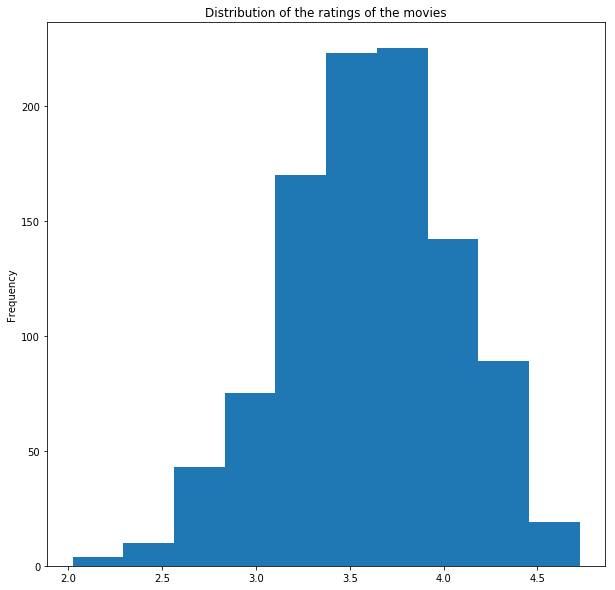

In [102]:
#The distribution of the mean of the rating of each movie
means = split.groupby('Movie').mean()
means = means['eval']
means.plot(kind='hist',figsize=(10,10),title='Distribution of the ratings of the movies')

# 3. Defining our model

In order to train our model, we define some methods that could be useful for the rest.

In [16]:
# A function to split the data
def generate_sample(df,ratio=0.8):
    """
        Df: the dataframe on which we wish to split the data
        ratio: the ration of the split
    """
    
    # the train and test sets
    traine=df.sample(frac=ratio)
    teste=df.drop(train.index)
    
    # the train inputs and outputs
    traineY=traine['eval']
    traineX=traine.drop(['eval'], axis=1)
    
    # the test inputs and outputs
    testeY=teste['eval']
    testeX=teste.drop(['eval'],axis=1)
    
    return traineX,traineY,testeX,testeY

trainX,trainY,testX,testY = generate_sample(split,0.8)

We begin with a simple Random Forest classifier, just to explore what can be done.

In [96]:
# prediction method given the random forest model
def predict_random_forest(trainx, trainy, testx, n=100, depth=None):
    """
        trainx: the training input data 
        trainy: the training output data
        testx: the testing input data
        n: the number of estimators
        depth: the max depth of the trees
    """
    clf = RandomForestClassifier(n_estimators=n, max_depth=depth)
    clf.fit(trainx, trainy)
    return clf.predict(testx[trainx.columns.values])

In [97]:
prediction = predict_random_forest(trainX,trainY,testX)

In [98]:
error = mean_squared_error(testY,prediction)**0.5

In [99]:
error

0.6460657157979595

In [100]:
matrix=confusion_matrix(testY,prediction)

In [101]:
matrix

array([[ 7080,   219,   510,   415,   465],
       [  212, 16415,  1095,   993,  1107],
       [  445,  1058, 46978,  2985,  3521],
       [  379,   996,  3133, 55793,  4823],
       [  414,  1035,  3426,  4675, 77218]], dtype=int64)

# 4. Predictions on the submission

We first open the csv containing the sample in order to obtain the testing data, we then split this data to get the users and movies in seperate columns using our defined method.

In [36]:
submission = pd.read_csv('data/sample_submission.csv')

In [37]:
submission.head()

,Id,Prediction
0,r37_c1,3
1,r73_c1,3
2,r156_c1,3
3,r160_c1,3
4,r248_c1,3


In [40]:
test = splitting(submission)